In [1]:
#BERT（Bidirectional Encoder Representations from Transformers）是由Google在2018年提出的预训练语言模型。
#它通过Transformer架构和双向训练机制，能深度理解词语在上下文中的语义，显著提升了NLP任务的效果。
#  双向上下文编码：同时考虑词语左右两侧的上下文
#  预训练+微调范式：先在无标注数据上预训练，再针对具体任务微调
#  Transformer编码器：基于自注意力机制处理长距离依赖

# pip install transformers torch

#export HF_ENDPOINT=https://hf-mirror.com
#huggingface-cli download bert-base-uncased --local-dir /mnt/workspace/ai/models/bert-base-uncased

from transformers import BertTokenizer, BertModel
import torch

# 加载预训练模型和分词器
model_name = "/mnt/workspace/ai/models/bert-base-uncased"  # 常用基础模型
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [6]:
# 处理输入文本
text = "BERT understands contextual semantics."
inputs = tokenizer(
    text, 
    return_tensors="pt",       # 返回PyTorch张量
    padding=True,              # 自动填充
    truncation=True,           # 自动截断
    max_length=128,            # 最大长度
    add_special_tokens=True    # 添加[CLS]和[SEP]
)

In [7]:
# 提取句子向量 方法一：使用[CLS]标记向量（官方推荐） [CLS]位于句首，其向量被设计为聚合全句信息：

with torch.no_grad():
    outputs = model(**inputs)

# 获取[CLS]对应的向量（索引0）
cls_vector = outputs.last_hidden_state[:, 0, :]  
print("CLS向量形状:", cls_vector.shape)  # torch.Size([1, 768])

# 提取句子向量 方法二：平均所有Token向量 对非填充Token取平均，更关注实际内容：

token_vectors = outputs.last_hidden_state
attention_mask = inputs["attention_mask"]

# 扩展mask维度并计算有效Token均值
mask_expanded = attention_mask.unsqueeze(-1).expand(token_vectors.size())
sum_vectors = torch.sum(token_vectors * mask_expanded, dim=1)
mean_vector = sum_vectors / torch.clamp(mask_expanded.sum(1), min=1e-9)


CLS向量形状: torch.Size([1, 768])


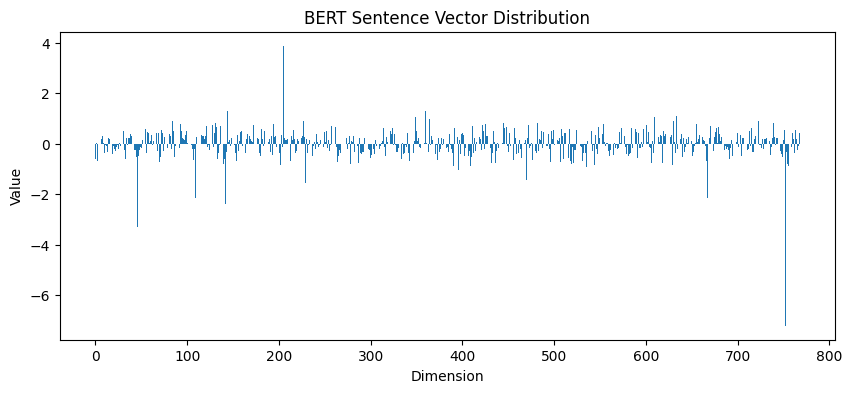

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 转换为numpy数组
vector_np = cls_vector.numpy().flatten()

# 绘制向量分布
plt.figure(figsize=(10, 4))
plt.bar(range(len(vector_np)), vector_np)
plt.title("BERT Sentence Vector Distribution")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.show()

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# 测试一词多义
text1 = "I deposited money in the bank."
text2 = "We fished by the river bank."

def analyze_polysemy(text1, text2, target_word="bank"):
    # 标记化并获取单词位置
    tokens1 = tokenizer.tokenize(text1)
    tokens2 = tokenizer.tokenize(text2)
    
    # 找到目标词的位置
    word_id1 = tokens1.index(target_word)
    word_id2 = tokens2.index(target_word)
    
    # 编码句子
    inputs1 = tokenizer(text1, return_tensors="pt")
    inputs2 = tokenizer(text2, return_tensors="pt")
    
    # 获取隐藏状态
    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)
    
    # 提取目标词的向量 (第0层是输入层)
    word_vector1 = outputs1.last_hidden_state[0, word_id1+1]  # +1 跳过[CLS]
    word_vector2 = outputs2.last_hidden_state[0, word_id2+1]
    
    # 提取句子向量 (使用[CLS])
    sentence_vector1 = outputs1.last_hidden_state[0, 0]
    sentence_vector2 = outputs2.last_hidden_state[0, 0]
    
    # 计算相似度
    word_similarity = cosine_similarity(
        word_vector1.numpy().reshape(1, -1), 
        word_vector2.numpy().reshape(1, -1)
    )[0][0]
    
    sentence_similarity = cosine_similarity(
        sentence_vector1.numpy().reshape(1, -1), 
        sentence_vector2.numpy().reshape(1, -1)
    )[0][0]
    
    return {
        "word_similarity": word_similarity,
        "sentence_similarity": sentence_similarity,
        "tokens1": tokens1,
        "tokens2": tokens2
    }

# 执行分析
results = analyze_polysemy(text1, text2)

# 打印结果
print("句子1分词:", results["tokens1"])
print("句子2分词:", results["tokens2"])
print("\n相同单词相似度 ('bank'):", f"{results['word_similarity']:.4f}")
print("整句相似度:", f"{results['sentence_similarity']:.4f}")

句子1分词: ['i', 'deposited', 'money', 'in', 'the', 'bank', '.']
句子2分词: ['we', 'fished', 'by', 'the', 'river', 'bank', '.']

相同单词相似度 ('bank'): 0.5499
整句相似度: 0.7796
